# EDA

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score, auc, make_scorer
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV,  StratifiedKFold
from xgboost import XGBClassifier
import optuna
import xgboost as xgb
import pandas as pd

import h5py
from PIL import Image
import io
import os
import cv2

import numpy as np
%matplotlib inline

import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf
import keras_cv

from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression



#### > Create directory paths for the project

In [24]:

#General file paths
#projectDir = os.getcwd() + "/"
#parentDir = os.path.abspath(os.path.join(projectDir, os.pardir)) + "/"
dataPath = "C:/Users/admin/Documents/DSTI/DeepLearning/Project/Computer_Vision/isic-2024-challenge/"


#Metadata file paths
metaPath = dataPath + "train-metadata.csv"
#metaPath = dataPath + "sample-metadata.csv"

#Image file path
hdf5_file = dataPath + "train-image.hdf5"
#hdf5_file = dataPath + "sample-image.hdf5"


In [25]:
dataPath

'C:/Users/admin/Documents/DSTI/DeepLearning/Project/Computer_Vision/isic-2024-challenge/'

#### > Import training metadata

In [26]:
metadata = pd.read_csv(dataPath + "train-metadata.csv", sep=",")

C:\Users\admin\AppData\Local\Temp\ipykernel_2332\3897865793.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(dataPath + "train-metadata.csv", sep=",")


#### > Check metadata for one image

In [27]:
metadata[metadata["tbp_lv_color_std_mean"] == metadata["tbp_lv_color_std_mean"].max()]

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
201543,ISIC_5071401,0,IP_2331257,55.0,female,posterior torso,10.57,TBP tile: close-up,3D: XP,25.034564,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.889719


Examine a sample set of images

In [28]:
#normal, hairs1, hairs2, wrinkles1, wrinkles2, protrusions
trial_image_files = ["ISIC_0015670", "ISIC_0052213", "ISIC_0075726", "ISIC_0076172", "ISIC_8570031", "ISIC_5071401"]

#Filename and image id
file = dataPath + "train-image.hdf5"
#isic_id = "ISIC_0015670"

#Import hdf5 file and one image
trial_images = []
f = h5py.File(file, mode="r")
for isic_id in trial_image_files:
    image = np.array(
        Image.open(
            io.BytesIO(f[isic_id][()])
            )
        )
    trial_images.append(image)

#Find dimensions of the image (it is supposed to be 180 pixels if the image is 15mmx15mm)
print("Height of image in pixels =", len(trial_images[0])) #Image 0 - rows
print("Width of image in pixels =", len(trial_images[0][0])) #Image 0 - columns
#Show a line going through the middle of the image 1
trial_images[1][70]

Height of image in pixels = 139
Width of image in pixels = 139


array([[209, 167, 145],
       [205, 163, 141],
       [205, 163, 141],
       [211, 169, 147],
       [215, 173, 151],
       [211, 169, 147],
       [205, 163, 141],
       [202, 160, 138],
       [190, 148, 126],
       [193, 151, 129],
       [198, 156, 134],
       [201, 159, 137],
       [202, 160, 138],
       [199, 157, 135],
       [195, 153, 131],
       [192, 150, 128],
       [189, 147, 125],
       [194, 152, 130],
       [199, 157, 135],
       [201, 159, 137],
       [200, 158, 136],
       [200, 158, 136],
       [203, 161, 139],
       [206, 164, 142],
       [212, 170, 148],
       [208, 166, 144],
       [204, 162, 140],
       [204, 162, 140],
       [206, 164, 142],
       [210, 168, 146],
       [213, 171, 149],
       [214, 172, 150],
       [199, 157, 135],
       [201, 160, 138],
       [202, 161, 139],
       [199, 161, 138],
       [201, 165, 141],
       [201, 165, 141],
       [193, 159, 134],
       [182, 148, 123],
       [171, 137, 112],
       [196, 162

In [ ]:
#Show the images
for image in trial_images:
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()

AJOUT DISTRIBUTION TAILLE ET INDICATEUR SUR LES IMAGES (CHEVEUX ET PEAUX FONCEES)

In [30]:
# inspire with the DULL RAZOR algo (REMOVE HAIR)
def detect_hairs_threshold(image_data, crop_pixels=10, hair_density_threshold=40.0):
    
    # Load image
    image = Image.open(io.BytesIO(image_data))
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    height_pixels = image.shape[0]  # Image rows
    width_pixels = image.shape[1]   # Image columns

    # Image cropping 
    height = [crop_pixels, height_pixels - crop_pixels]
    width = [crop_pixels, width_pixels - crop_pixels]
    cropped_img = image[height[0]:height[1], width[0]:width[1]]
    
    #Gray sclae
    grayScale = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    
    # Black Hat filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # Gaussian Blur
    blurred = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    
    # Binary thresholding to create a mask
    _, mask = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)
    
    # Calculate the density of hair pixels
    hair_pixels = np.sum(mask > 0)
    total_pixels = mask.size
    hair_density = (hair_pixels / total_pixels) * 100  # Percentage of hair pixels
    
    # Return True if the hair density exceeds the specified threshold
    return hair_density > hair_density_threshold

In [31]:
def detect_dark_skin(image_data):
    # Load the image
    image = Image.open(io.BytesIO(image_data))
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # HSV range for dark skin tones 
    lower_skin = np.array([0, 80, 60], dtype=np.uint8) #to adapt -difficult to find good reference for the range
    upper_skin = np.array([140, 180, 140], dtype=np.uint8) #to adapt
    
    # Create a mask for dark skin regions
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    
    # Percentage of dark skin pixels
    skin_pixel_count = np.sum(mask > 0)
    total_pixel_count = mask.size
    skin_pixel_percentage = (skin_pixel_count / total_pixel_count) * 100
    
    # Return True if the percentage of dark skin pixels is above the threshold
    skin_threshold = 90  #to adapt
    return skin_pixel_percentage > skin_threshold


In [32]:
def extract_image_data_to_dataframe(hdf5_file_path, batch_size):
    data_list = []

    try:
        with h5py.File(hdf5_file_path, 'r') as hdf:
            dataset_ids = list(hdf.keys())
            total_images = len(dataset_ids)
            num_batches = (total_images + batch_size - 1) // batch_size

            for batch_index in range(num_batches):
                start_index = batch_index * batch_size
                end_index = min(start_index + batch_size, total_images)
                selected_ids = dataset_ids[start_index:end_index]

                for dataset_id in selected_ids:
                    data = hdf[dataset_id]
                    if isinstance(data, h5py.Dataset) and data.shape == ():
                        image_data = data[()]

                        # Load the image to get dimensions
                        image = Image.open(io.BytesIO(image_data))
                        width, height = image.size

                        # Detect dark skin
                        has_dark_skin = detect_dark_skin(image_data)

                        # Detect hair
                        has_hair = detect_hairs_threshold(image_data,hair_density_threshold=5)
                        lot_of_hair = detect_hairs_threshold(image_data,hair_density_threshold=40)

                        # Determine if both dark skin and a lot of hair are present
                        dark_skin_and_lot_of_hair = has_dark_skin and lot_of_hair

                        # Append the data to the list
                        data_list.append([dataset_id, width, height, 
                                          'Yes' if has_hair else 'No', 
                                          'Yes' if lot_of_hair else 'No', 
                                          'Yes' if has_dark_skin else 'No', 
                                          'Yes' if dark_skin_and_lot_of_hair else 'No'])

                #print(f"Processed batch {batch_index + 1} of {num_batches}")

        # Create DataFrame after processing
        df = pd.DataFrame(data_list, columns=['PhotoID', 'Width', 'Height', 'Has Hair', 'Lot of Hair', 'Dark Skin', 'Dark Skin and Lot of Hair'])
        print("Data extraction complete.")

        return df

    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Call the function and store the DataFrame
df = extract_image_data_to_dataframe(hdf5_file, batch_size=1000)

# Display the DataFrame
print(df.head())


Data extraction complete.
        PhotoID  Width  Height Has Hair Lot of Hair Dark Skin  \
0  ISIC_0015670    139     139      Yes          No        No   
1  ISIC_0015845    127     127      Yes         Yes        No   
2  ISIC_0015864    145     145      Yes          No        No   
3  ISIC_0015902    109     109      Yes          No       Yes   
4  ISIC_0024200    125     125      Yes         Yes        No   

  Dark Skin and Lot of Hair  
0                        No  
1                        No  
2                        No  
3                        No  
4                        No  


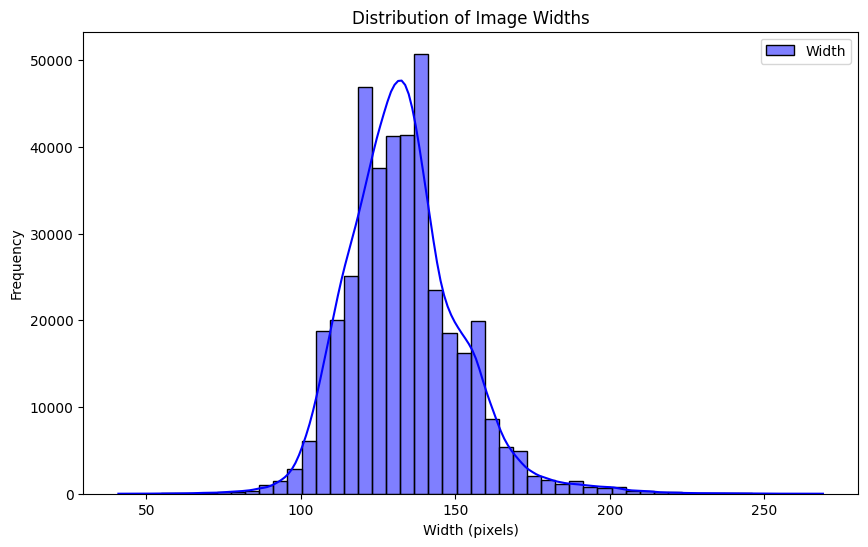

Mean of width: 133.2


In [38]:
# width histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Width'], bins=50, kde=True, color='blue', label='Width')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate the mean of the 'width'
width_mean = round(df['Width'].mean(), 1)
# Print the result
print(f"Mean of width: {width_mean}")


In [15]:
#calculate nmber of image with these parameters: hair, Dark skin, lot of hairs
total_observations=len(df)
hair_count = df[df['Has Hair'] == 'Yes'].shape[0]
pourcentage_hair=hair_count/total_observations

lot_hair_count = df[df['Lot of Hair'] == 'Yes'].shape[0]
pourcentage_lot_hair=lot_hair_count/total_observations

Dark_skin_count = df[df['Dark Skin'] == 'Yes'].shape[0]
pourcentage_Dark_skin=Dark_skin_count/total_observations

Ds_Lh_count = df[df['Dark Skin and Lot of Hair'] == 'Yes'].shape[0]
pourcentage_Ds_Lh=Ds_Lh_count/total_observations

# Display
print(f"Number with hair : {hair_count}, Proportion with hair : {pourcentage_hair:.2%}")
print(f"Number with lot of hair : {lot_hair_count}, Proportion with lot of hair : {pourcentage_lot_hair:.2%}")
print(f"Number with dark sin : {Dark_skin_count}, Proportion with dark skin : {pourcentage_Dark_skin:.2%}")
print(f"Number with dark sin and lot of hairs : {Ds_Lh_count}, Proportion with dark skin and lot of hairs : {pourcentage_Ds_Lh:.2%}")

Number with hair : 326875, Proportion with hair : 81.50%
Number with lot of hair : 43394, Proportion with lot of hair : 10.82%
Number with dark sin : 18851, Proportion with dark skin : 4.70%
Number with dark sin and lot of hairs : 676, Proportion with dark skin and lot of hairs : 0.17%


## III- TEST IMAGES PREPROCESSING AND AUGMENTATION

#### > Apply a hair removing algorithm (Dull Razor)

In [8]:
#Code taken and modified from https://github.com/BlueDokk/Dullrazor-algorithm.git
# Author: Javier Velasquez P.
# Date:Created on Tue Feb 18 11:42:26 2020
    
#DULL RAZOR (REMOVE HAIR)
#Provides a cleaned output image and the mean absolute difference between the images for each color in RGB
def hair_removal(image, crop_pixels = 10, dsply_images = False):

    height_pixels = len(image) #Image rows
    width_pixels = len(image[0]) #Image columns

    #Image cropping
    crop_pixels = 10
    height = [crop_pixels, height_pixels-crop_pixels]
    width = [crop_pixels, width_pixels-crop_pixels]
    img=image[height[0]:height[1],width[0]:width[1]]
    
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)

    #Calculate the difference between initial an final images
    h = len(img)
    w = len(img[0])
    diff = np.absolute(img - dst)/(h*w)
    diff = np.sum(diff,axis=(0,1))

    #Display images
    if dsply_images:
        img_list = [image, img, grayScale, blackhat, mask, dst]
        for item in img_list:
            plt.imshow(item)
            plt.grid(None)
            plt.show()

    return dst, diff

#### > Apply image sharpening

In [9]:

#Sharpen image (subract a blurred image from the inital image, applying weights)
def sharpen(image, shrp_weight = 0.5):
    blur = cv2.GaussianBlur(image, (0, 0), 2)
    shrp = cv2.addWeighted(image, 1 + shrp_weight, blur, -shrp_weight, 0)
    return shrp
    

In [10]:
#img_num = 4

> Apply various transformation (hair/wrinkles removal, sharpening, Brightness, flip, contrast, saturation, resize)

In [ ]:
# Define RandomCutout layer from KerasCV
cutout_layer = keras_cv.layers.RandomCutout(height_factor=0.6, width_factor=0.6)

# Function to apply transformations and display images
def apply_transformations_and_display(images):
    # Define the transformation labels
    transformation_labels = [
        'Original',
        'hair removal',
        'hair removal + low sharp.',
        'hair removal + high sharpening',
        'Flip Left-Right',
        'Flip Up-Down',
        'Rotate 90 Degrees',
        'Rotate 270 Degrees',
        'Rotate 180 Degrees',
        'Brightness -0.25',
        'Brightness -0.15',
        'Brightness -0.05',
        'Brightness +0.05',
        'Brightness +0.15',
        'Brightness +0.25',
        'Contrast 0.7',
        'Contrast 0.95',
        'Contrast 1.05',
        'Contrast 1.2',
        'Contrast 1.8',
        'Saturation 0.7',
        'Saturation 0.95',
        'Saturation 1.05',
        'Saturation 1.2',
        'Saturation 1.8',
        'Cutout Transformation',
        'Resize 100X100'
    ]
    
    #loop over the images
    for image in images:
        img, diff = hair_removal(image)
        img_sharp_low, diff = hair_removal(sharpen(image, shrp_weight=0.2))
        img_sharp_high, diff = hair_removal(sharpen(image, shrp_weight=0.5))
        # Additional transformations
        transformations = [
            image,  # Original image
            img,
            img_sharp_low,
            img_sharp_high,
            tf.image.flip_left_right(image),
            tf.image.flip_up_down(image),
            tf.image.rot90(image, 1),
            tf.image.rot90(image, 3),
            tf.image.rot90(image, 2),
            tf.image.adjust_brightness(image, -0.25),
            tf.image.adjust_brightness(image, -0.15),
            tf.image.adjust_brightness(image, -0.05),
            tf.image.adjust_brightness(image, 0.05),
            tf.image.adjust_brightness(image, 0.15),
            tf.image.adjust_brightness(image, 0.25),
            tf.image.adjust_contrast(image, 0.7),
            tf.image.adjust_contrast(image, 0.95),
            tf.image.adjust_contrast(image, 1.05),
            tf.image.adjust_contrast(image, 1.2),
            tf.image.adjust_contrast(image, 1.8),
            tf.image.adjust_saturation(image, 0.7),
            tf.image.adjust_saturation(image, 0.95),
            tf.image.adjust_saturation(image, 1.05),
            tf.image.adjust_saturation(image, 1.2),
            tf.image.adjust_saturation(image, 1.8),
            cutout_layer(image),  # Apply RandomCutout transformation
            tf.image.resize(image,[100,100]) 
        ]
    
        # Display the transformed images
        plt.figure(figsize=(15, 15))
        for i, transformed_image in enumerate(transformations):
            plt.subplot(5, 7, i + 1)
            plt.imshow(transformed_image/255 )
            plt.title(transformation_labels[i])
            plt.axis('off')
        plt.show()


# Apply transformations and display
apply_transformations_and_display(trial_images)


## IV- METADATA

#### Create a display function permitting easy adjustment of max_rows and max_columns options (Pandas dataframes)

In [24]:
#A pandas dataframe must be the input
#head_tail: 0 = neither, 1 = head, 2 = tail
#Enter "None" (without quotes) as the value of nb_rows or nb_cols if the standard limit should be applied (60 rows & 20 columns)
def display_more(df, head_tail = 0, nb_rows=60, nb_cols= pd.options.display.max_columns):
    with pd.option_context('display.max_rows', nb_rows, 'display.max_columns', nb_cols):
        if head_tail == 1:
            display(df.head())
        elif head_tail == 2:
            display(df.tail())
        else:
            display(df)

#### > Examine the metadata

In [25]:
#Display the first lines
display_more(metadata, head_tail = 1, nb_cols=55)
#Display basic statistical data
display_more(metadata.describe(), nb_cols=55)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,60.996869,42.289976,51.199529,8.539975,19.084517,1.070408,5.054760,1.368691,-8.909552,9.455766,7.538922,0.741238,2.539773,38.520265,3.451523,3.091590,11.878891,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,5.631909,10.864572,12.100527,9.679312,5.357863,0.762918,2.642928,2.215871,3.463362,3.466703,2.404951,0.143857,1.173169,41.480936,1.724557,2.044813,5.919302,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,28.436490,4.223007,17.702260,0.431601,10.761634,0.000000,-13.819850,-18.088106,-38.756140,2.952675,3.001138,0.027667,0.273973,0.000000,0.589426,0.000000,2.579237,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,57.297630,34.303345,42.274506,4.109589,15.426205,0.574909,3.413108,0.111030,-10.675470,6.952377,5.748160,0.656627,1.812707,0.109819,2.143836,1.728774,8.338364,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,61.109173,42.343770,51.425557,5.685870,17.423950,0.931402,4.643926,1.593945,-8.132223,8.699932,6.946320,0.768215,2.265201,14.408514,2.996933,2.764664,10.015440,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,64.905025,50.405051,60.495607,9.119910,21.011340,1.412154,6.274246,2.850638,-6.397103,11.243486,8.748403,0.853175,2.905918,87.791395,4.358399,4.120246,13.209100,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,130.983300,87.548888,98.588250,334.152700,87.205340,9.952932,32.137590,12.643930,-1.590631,39.197720,30.487456,0.974960,18.387900,100.000000,10.000000,10.000000,102.493900,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [26]:
#Display other summary data (NA counts, data types)
metadata_summary = pd.DataFrame(metadata.isna().sum(), columns=["NA_occurrences"])
metadata_summary["data_type"] = metadata.dtypes
temp = metadata.describe().transpose().drop(columns=["count","std"])
metadata_summary = metadata_summary.join(temp)
display_more(metadata_summary, nb_rows=100)

,NA_occurrences,data_type,mean,min,25%,50%,75%,max
isic_id,0,object,NaN,NaN,NaN,NaN,NaN,NaN
target,0,int64,0.000980,0.000000e+00,0.000000,0.000000,0.000000,1.000000
patient_id,0,object,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,2798,float64,58.012986,5.000000e+00,50.000000,60.000000,70.000000,85.000000
sex,11517,object,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,5756,object,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,0,float64,3.930827,1.000000e+00,2.840000,3.370000,4.380000,28.400000
image_type,0,object,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,0,object,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,0,float64,19.974007,-2.487115e+00,17.330821,19.801910,22.304628,48.189610


#### > Target

target
0    400666
1       393 



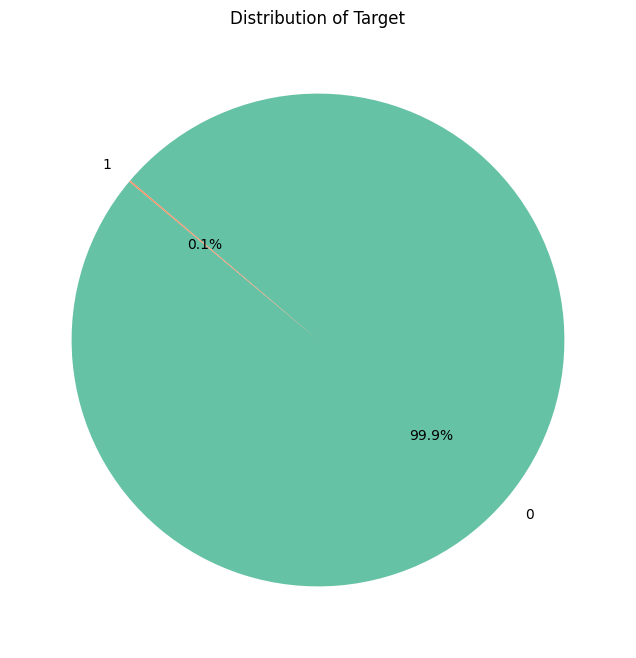

In [20]:
# Plot the distribution of 'target' for images
target_counts = metadata['target'].value_counts()

print(target_counts.to_string(), "\n") 
 
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Distribution of Target")
plt.show()

#### > Look at the data per patient

In [27]:
# Check for duplicates in the 'isic_id' column
duplicates = metadata.duplicated(subset='patient_id', keep=False)
duplicate_rows = metadata[duplicates]
 
# Count the number of duplicate rows
num_duplicates = duplicate_rows.shape[0]
 
# Display the results
print(f"Number of duplicate rows based on 'patient_id': {num_duplicates}")

Number of duplicate rows based on 'patient_id': 401054


In [28]:
#Display 10 first duplicate
print(duplicate_rows.head(10))

        isic_id  target  patient_id  age_approx     sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0    male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0    male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0    male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0    male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0    male      anterior torso   
5  ISIC_0035502       0  IP_3026693        75.0  female           head/neck   
6  ISIC_0051648       0  IP_0218255        65.0    male     upper extremity   
7  ISIC_0051665       0  IP_7734648        50.0    male     posterior torso   
8  ISIC_0051710       0  IP_1307115        50.0    male      anterior torso   
9  ISIC_0051758       0  IP_2180091        60.0  female     upper extremity   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3

In [29]:
# Example of duplicate
# Specify the patient IDs to filter
patient_ids = ['IP_1235828', 'IP_8170065']
 
# Filter the DataFrame for the specified patient IDs
is_patient_id = metadata['patient_id'].isin(patient_ids)
filtered_data = metadata[is_patient_id]
print(filtered_data)

             isic_id  target  patient_id  age_approx   sex  \
0       ISIC_0015670       0  IP_1235828        60.0  male   
1       ISIC_0015845       0  IP_8170065        60.0  male   
131     ISIC_0076432       0  IP_1235828        60.0  male   
2072    ISIC_0124587       0  IP_1235828        60.0  male   
2332    ISIC_0130299       0  IP_1235828        60.0  male   
...              ...     ...         ...         ...   ...   
397840  ISIC_9919878       0  IP_1235828        60.0  male   
398195  ISIC_9929307       0  IP_1235828        60.0  male   
398396  ISIC_9934582       0  IP_1235828        60.0  male   
399576  ISIC_9963797       0  IP_1235828        60.0  male   
400809  ISIC_9994034       0  IP_8170065        60.0  male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
0          lower extremity                    3.04  TBP tile: close-up   
1                head/neck                    1.10  TBP tile: close-up   
131        posterior torso       

In [15]:
#Number of unique patient
# Drop duplicate rows based on 'patient_id'
unique_patients = metadata.drop_duplicates(subset='patient_id')
unique_patients_count = unique_patients['patient_id'].nunique()
# Print the result
print(f"Number of unique patient: {unique_patients_count}")

 
#Number of picture by patient
# Count the number of photos (isic_id) for each patient (patient_id)
photo_counts = metadata.groupby('patient_id').size()
 
# Calculate the average number of photos per patient
average_photos_per_patient = photo_counts.mean()
 
# Print the result
print(f"Average number of photos per patient: {average_photos_per_patient:.2f}")

Number of unique patient: 1042
Average number of photos per patient: 384.89


#### > Histograms

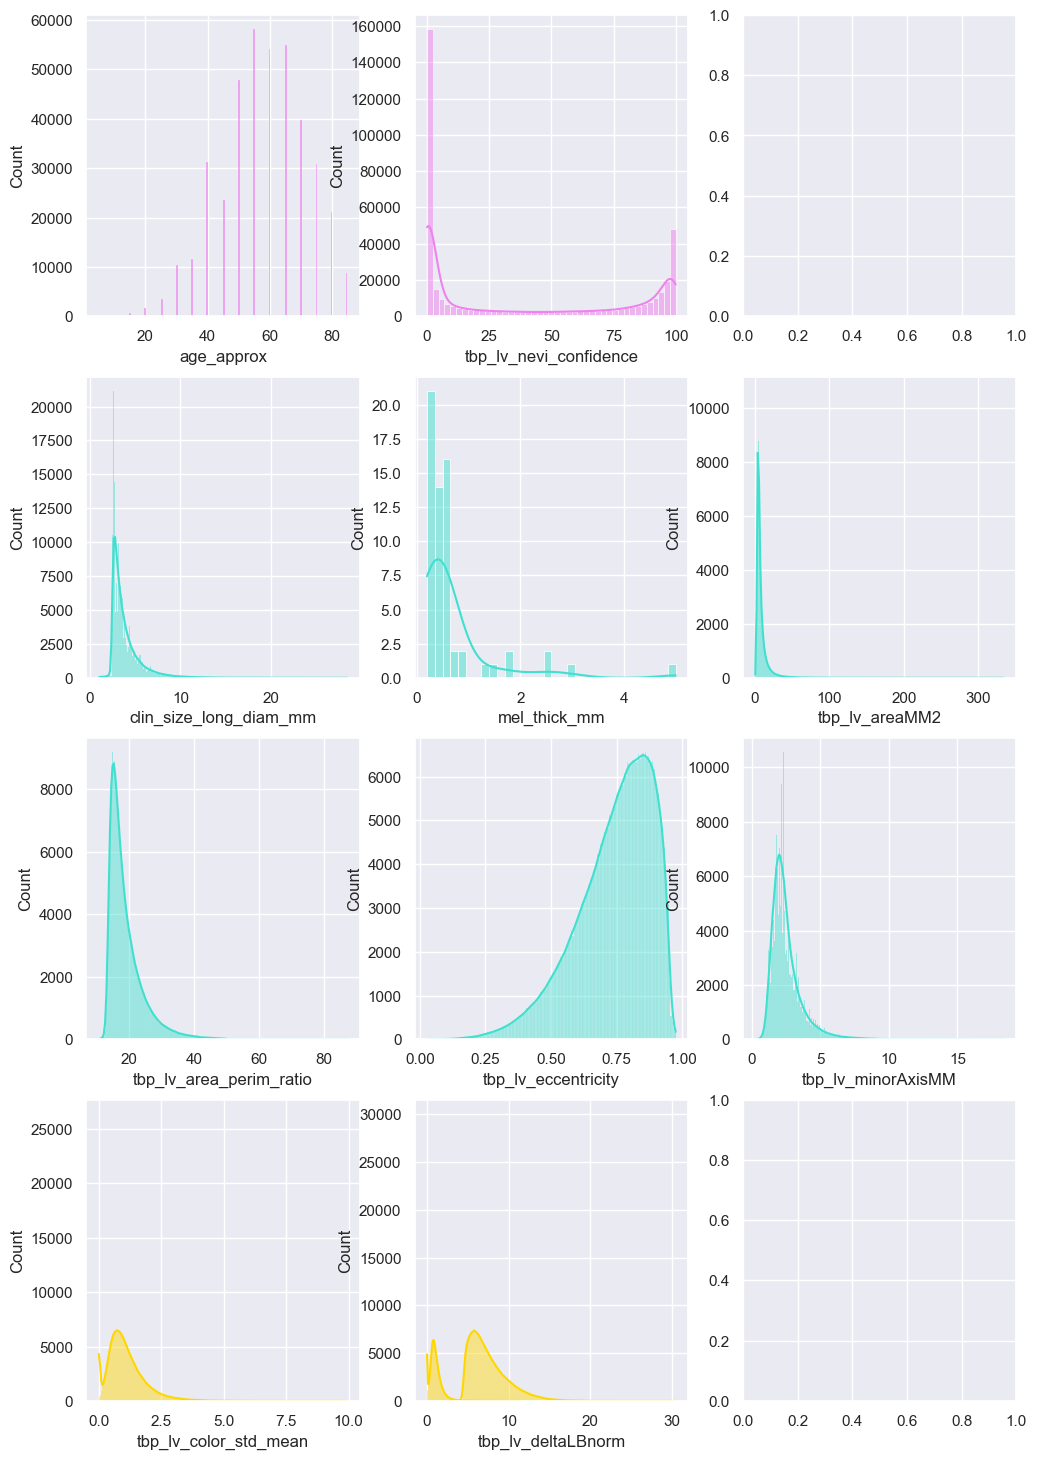

In [32]:
#Define dataframe to plot
df = metadata
#Set Seaborn theme
sns.set_theme(style="darkgrid")
#Establish multi-plot dimensions
fig, pos = plt.subplots(nrows=4, ncols=3, figsize=(12, 18))
###--- Create plots ---###
#General Data
sns.histplot(data=df, x="age_approx", kde=False, color="violet", ax=pos[0, 0]) #Age of patient
sns.histplot(data=df, x="tbp_lv_nevi_confidence", kde=True, color="violet", ax=pos[0, 1]) #probability that the lesion is a nevus
#Shape and size data 1
sns.histplot(data=df, x="clin_size_long_diam_mm", kde=True, color="turquoise", ax=pos[1, 0]) #Maximum diameter of the lesion (mm)
sns.histplot(data=df, x="mel_thick_mm", kde=True, color="turquoise", ax=pos[1, 1]) #Thickness in depth of melanoma invasion (*only in training data)
sns.histplot(data=df, x="tbp_lv_areaMM2", kde=True, color="turquoise", ax=pos[1, 2]) #Area of lesion (mm^2)
#Shape and size data 2
sns.histplot(data=df, x="tbp_lv_area_perim_ratio", kde=True, color="turquoise", ax=pos[2, 0]) #Border jaggedness, the ratio between lesions perimeter and area
sns.histplot(data=df, x="tbp_lv_eccentricity", kde=True, color="turquoise", ax=pos[2, 1]) #Eccentricity of lesion
sns.histplot(data=df, x="tbp_lv_minorAxisMM", kde=True, color="turquoise", ax=pos[2, 2]) #Smallest lesion diameter (mm)
#Color data
sns.histplot(data=df, x="tbp_lv_color_std_mean", kde=True, color="gold", ax=pos[3, 0]) #Color irregularity
sns.histplot(data=df, x="tbp_lv_deltaLBnorm", kde=True, color="gold", ax=pos[3, 1]) #Contrast between the lesion and its immediate surrounding skin
sns.histplot(data=df, x="tbp_lv_radial_color_std_max", kde=True, color="gold", ax=pos[3, 1]) #Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion

plt.show()

#### > AGE

<Figure size 1200x800 with 0 Axes>

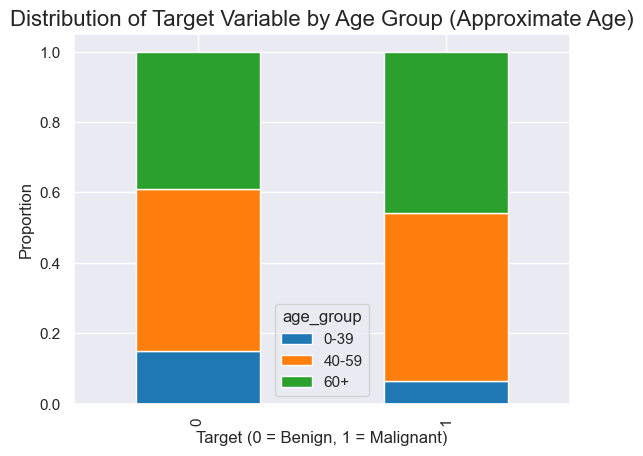

In [33]:
# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create age groups for clearer grouping
bins = [0,40, 60, 100]  
labels = ['0-39', '40-59', '60+']
metadata['age_group'] = pd.cut(metadata['age_approx'], bins=bins, labels=labels)

# Normalize the counts of each age group by target
age_group_freq = metadata.groupby('target')['age_group'].value_counts(normalize=True).unstack()

# plot the distribution of target by age group
age_group_freq.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e', '#2ca02c'])


# Set x and y axis labels
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Set the title of the plot
plt.title("Distribution of Target Variable by Age Group (Approximate Age)", fontsize=16)
plt.grid(True)

# Display plot
plt.show()


    The older age groups ("40-59", "60-79", "80+") tend to have more cases. This could indicate that as age increases, there is a higher frequency of cases.
    The age group "60-79" shows some notable contribution to malignant cases, suggesting that this age group may be at a higher risk



## Look at the data that is of type OBJECT

#### General data

#### > SEX

In [34]:
#sex: sex of the patient
print(metadata["sex"].value_counts())

sex
male      265546
female    123996
Name: count, dtype: int64


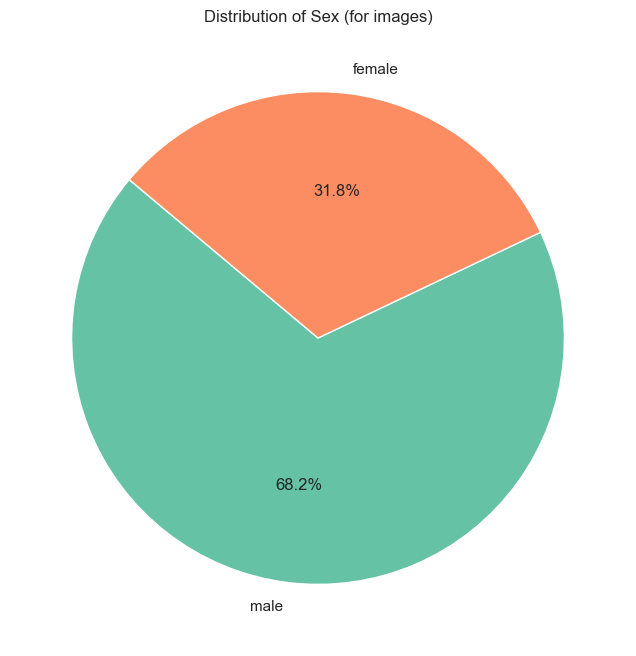

In [35]:
# Plot the distribution of 'sex' for images
sex_counts = metadata['sex'].value_counts()
 
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Distribution of Sex (for images)")
plt.show()

<Figure size 1200x800 with 0 Axes>

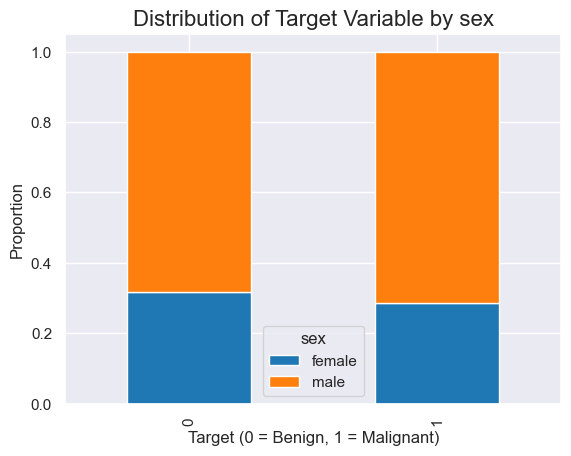

In [36]:
# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))


# Normalize the counts of each age group by target
sex_group_freq = metadata.groupby('target')['sex'].value_counts(normalize=True).unstack()

# plot the distribution of target by age group
sex_group_freq.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])


# Set x and y axis labels
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Set the title of the plot
plt.title("Distribution of Target Variable by sex", fontsize=16)
plt.grid(True)

# Display plot
plt.show()

Based on the plot, we can say that the difference in the distribution of benign and malignant cases between males and females is not extremely large. While there are more males in both benign and malignant categories, the difference is not substantial. Both sexes show a higher occurrence of benign cases, and the proportion of malignant cases seems similar for both.


#### > Anatomical Site

<Figure size 1200x800 with 0 Axes>

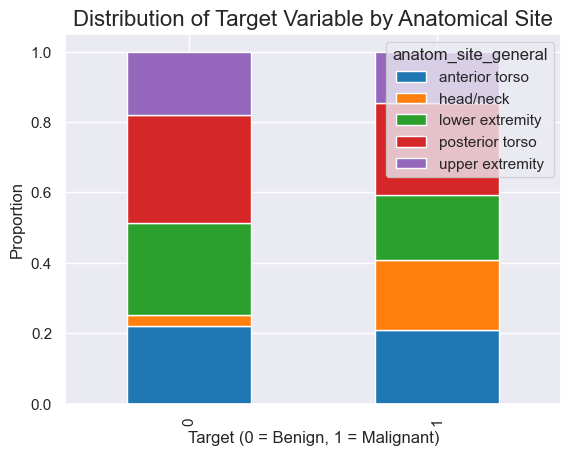

In [37]:
# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))


# Normalize the counts of each age group by target
sex_group_freq = metadata.groupby('target')['anatom_site_general'].value_counts(normalize=True).unstack()

# plot the distribution of target by age group
sex_group_freq.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


# Set x and y axis labels
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Set the title of the plot
plt.title("Distribution of Target Variable by Anatomical Site", fontsize=16)
plt.grid(True)

# Display plot
plt.show()


Posterior torso seems to have a relatively higher number of malignant cases, whereas lower extremity and anterior torso show a more balanced distribution between benign and malignant cases. Head/neck stands out for having more malignant cases despite the lower overall count, which might suggest a need for focused attention in this region. Overall, this distribution suggests certain anatomical sites, like the posterior torso and head/neck, may have higher malign

#### > Other features

In [38]:
#image_type: Structured field of the ISIC Archive for image type
print(metadata["image_type"].value_counts())

image_type
TBP tile: close-up    401059
Name: count, dtype: int64


In [39]:
#tbp_tile_type: Lighting modality of the 3D TBP source image
print(metadata["tbp_tile_type"].value_counts())

tbp_tile_type
3D: XP       285903
3D: white    115156
Name: count, dtype: int64


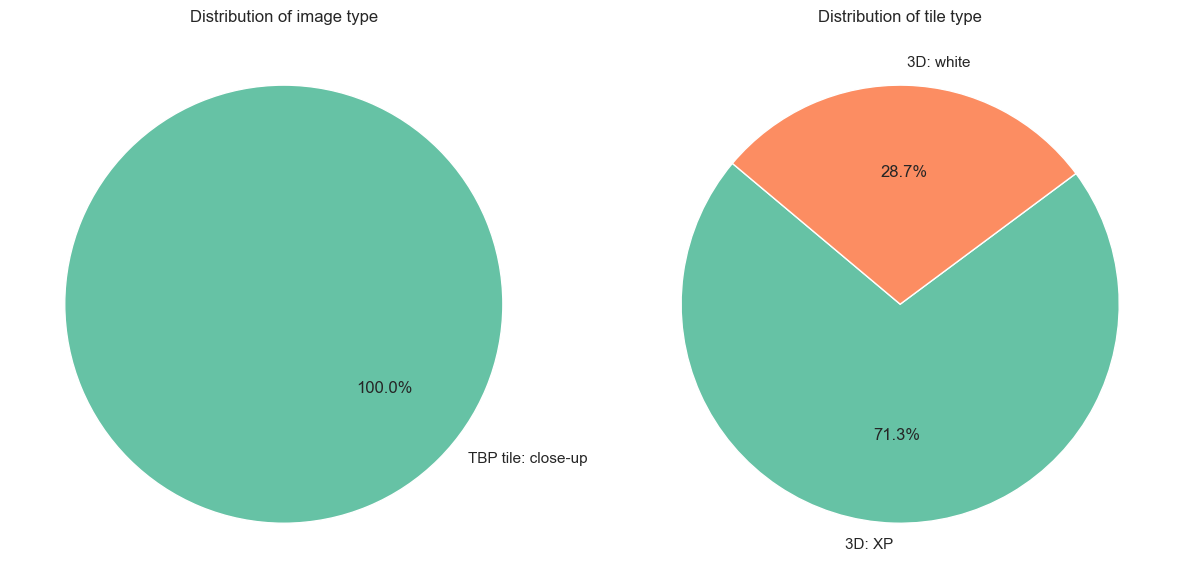

In [40]:
image_type_counts = metadata['image_type'].value_counts()
tile_type_counts = metadata['tbp_tile_type'].value_counts()
 
# Set up subplots: 2 rows, 2 columns
fig, pos = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
 
# Plot the first pie chart
pos[0].pie(image_type_counts, labels=image_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
pos[0].set_title("Distribution of image type")
 
# Plot the second pie chart
pos[1].pie(tile_type_counts, labels=tile_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
pos[1].set_title("Distribution of tile type")
 
 
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [41]:
#lesion_id: Unique lesion identifier. Present in lesions that were manually tagged as a lesion of interest
metadata["lesion_id"].dropna()

1         IL_6727506
49        IL_3854228
76        IL_9898853
93        IL_2988728
107       IL_6219432
             ...    
400997    IL_0041380
401019    IL_3334800
401028    IL_9124999
401054    IL_9520694
401056    IL_9852274
Name: lesion_id, Length: 22058, dtype: object

#### Lesion type

In [42]:
#iddx_full: First level lesion diagnosis
print(metadata["iddx_full"].value_counts(), "\n")
print("NAs in data:", metadata["iddx_full"].isna().sum())

iddx_full
Benign                                                                                                                                                           399991
Benign::Benign melanocytic proliferations::Nevus::Nevus, Atypical, Dysplastic, or Clark                                                                             228
Benign::Benign melanocytic proliferations::Nevus                                                                                                                    141
Malignant::Malignant adnexal epithelial proliferations - Follicular::Basal cell carcinoma::Basal cell carcinoma, Nodular                                             98
Indeterminate::Indeterminate melanocytic proliferations::Atypical melanocytic neoplasm                                                                               64
Benign::Benign epidermal proliferations::Seborrheic keratosis                                                                                         

In [43]:
#target
print(metadata["target"].value_counts(), "\n")
print("NAs in data:", metadata["target"].isna().sum())

target
0    400666
1       393
Name: count, dtype: int64 

NAs in data: 0


In [44]:
#iddx_1: First level lesion diagnosis
print(metadata["iddx_1"].value_counts(), "\n")
print("NAs in data:", metadata["iddx_1"].isna().sum())

iddx_1
Benign           400552
Malignant           393
Indeterminate       114
Name: count, dtype: int64 

NAs in data: 0


In [45]:
#iddx_2: First level lesion diagnosis
print(metadata["iddx_2"].value_counts(), "\n")
print("NAs in data:", metadata["iddx_2"].isna().sum())

iddx_2
Benign melanocytic proliferations                                 443
Malignant adnexal epithelial proliferations - Follicular          163
Malignant melanocytic proliferations (Melanoma)                   157
Benign epidermal proliferations                                    83
Indeterminate melanocytic proliferations                           75
Malignant epidermal proliferations                                 73
Indeterminate epidermal proliferations                             39
Benign soft tissue proliferations - Fibro-histiocytic              15
Inflammatory or infectious diseases                                 7
Flat melanotic pigmentations - not melanocytic nevus                5
Benign soft tissue proliferations - Vascular                        3
Cysts                                                               2
Benign adnexal epithelial proliferations - Follicular               2
Benign adnexal epithelial proliferations - Apocrine or Eccrine      1
Name: count, 

In [46]:
#iddx_3: First level lesion diagnosis
print(metadata["iddx_3"].value_counts(), "\n")
print("NAs in data:", metadata["iddx_3"].isna().sum())

iddx_3
Nevus                                                 443
Basal cell carcinoma                                  163
Melanoma in situ                                       80
Atypical melanocytic neoplasm                          64
Melanoma Invasive                                      63
Seborrheic keratosis                                   57
Squamous cell carcinoma in situ                        49
Solar or actinic keratosis                             39
Squamous cell carcinoma, Invasive                      22
Melanoma, NOS                                          13
Solar lentigo                                          12
Dermatofibroma                                         11
Atypical intraepithelial melanocytic proliferation     11
Lichen planus like keratosis                           11
Verruca                                                 7
Lentigo NOS                                             5
Pigmented benign keratosis                              3
Hemangi

In [47]:
#iddx_4: First level lesion diagnosis
print(metadata["iddx_4"].value_counts())

iddx_4
Nevus, Atypical, Dysplastic, or Clark                                             228
Basal cell carcinoma, Nodular                                                      98
Basal cell carcinoma, Superficial                                                  48
Melanoma Invasive, Superficial spreading                                           37
Nevus, NOS, Compound                                                               30
Nevus, NOS, Dermal                                                                 20
Melanoma in situ, Lentigo maligna type                                             12
Melanoma in situ, associated with a nevus                                          12
Nevus, NOS, Junctional                                                             10
Melanoma in situ, Superficial spreading                                            10
Melanoma Invasive, Associated with a nevus                                          7
Basal cell carcinoma, Infiltrating             

In [48]:
#iddx_5: First level lesion diagnosis
print(metadata["iddx_5"].value_counts())

iddx_5
Blue nevus, Cellular    1
Name: count, dtype: int64


#### Lesion size

In [49]:
#mel_mitotic_index: Mitotic index of invasive malignant melanomas
print(metadata["mel_mitotic_index"].value_counts())

mel_mitotic_index
0/mm^2     22
<1/mm^2    19
>4/mm^2     4
1/mm^2      3
3/mm^2      2
2/mm^2      2
4/mm^2      1
Name: count, dtype: int64


#### Position of lesion

In [50]:
#anatom_site_general: Location of the lesion on the patient's body
print(metadata["anatom_site_general"].value_counts())

anatom_site_general
posterior torso    121902
lower extremity    103028
anterior torso      87770
upper extremity     70557
head/neck           12046
Name: count, dtype: int64


In [51]:
#tbp_lv_location_simple: Classification of anatomical location (simple version)
print(metadata["tbp_lv_location_simple"].value_counts())

tbp_lv_location_simple
Torso Back     121902
Torso Front     87770
Left Leg        53075
Right Leg       49953
Left Arm        36348
Right Arm       34209
Head & Neck     12046
Unknown          5756
Name: count, dtype: int64


In [52]:
#tbp_lv_location: Classification of anatomical location (detailed version)
print(metadata["tbp_lv_location"].value_counts())

tbp_lv_location
Torso Back Top Third       71112
Torso Front Top Half       63350
Torso Back Middle Third    46185
Left Leg - Lower           27428
Right Leg - Lower          25208
Torso Front Bottom Half    24360
Left Leg - Upper           23673
Right Leg - Upper          23034
Right Arm - Upper          22972
Left Arm - Upper           22816
Head & Neck                12046
Left Arm - Lower           11939
Right Arm - Lower          10636
Unknown                     5756
Torso Back Bottom Third     4596
Left Leg                    1974
Right Leg                   1711
Left Arm                    1593
Right Arm                    601
Torso Front                   60
Torso Back                     9
Name: count, dtype: int64


In [53]:
# THE Unknown class is not present in the target == 1, so these images can be dropped
unknown_data = metadata[metadata['tbp_lv_location_simple'] == 'Unknown']
unknown_counts = unknown_data['target'].value_counts()
unknown_counts

target
0    5756
Name: count, dtype: int64

#### Source of data and copyright

In [54]:
#attribution: image source (hospital for example)
print(metadata["attribution"].value_counts())

attribution
Memorial Sloan Kettering Cancer Center                                                                                                                 129068
Department of Dermatology, Hospital Clínic de Barcelona                                                                                                105724
University Hospital of Basel                                                                                                                            65218
Frazer Institute, The University of Queensland, Dermatology Research Centre                                                                             51768
ACEMID MIA                                                                                                                                              28665
ViDIR Group, Department of Dermatology, Medical University of Vienna                                                                                    12640
Department of Dermatology, University of

In [55]:
#copyright_license: copyright from the data provider
print(metadata["copyright_license"].value_counts())

copyright_license
CC-BY       188812
CC-BY-NC    183582
CC-0         28665
Name: count, dtype: int64


# Correlation Matrix

In [56]:
numerics = metadata.select_dtypes(include=[float, int]).columns
numerics

Index(['target', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence'],
      dtype='object')

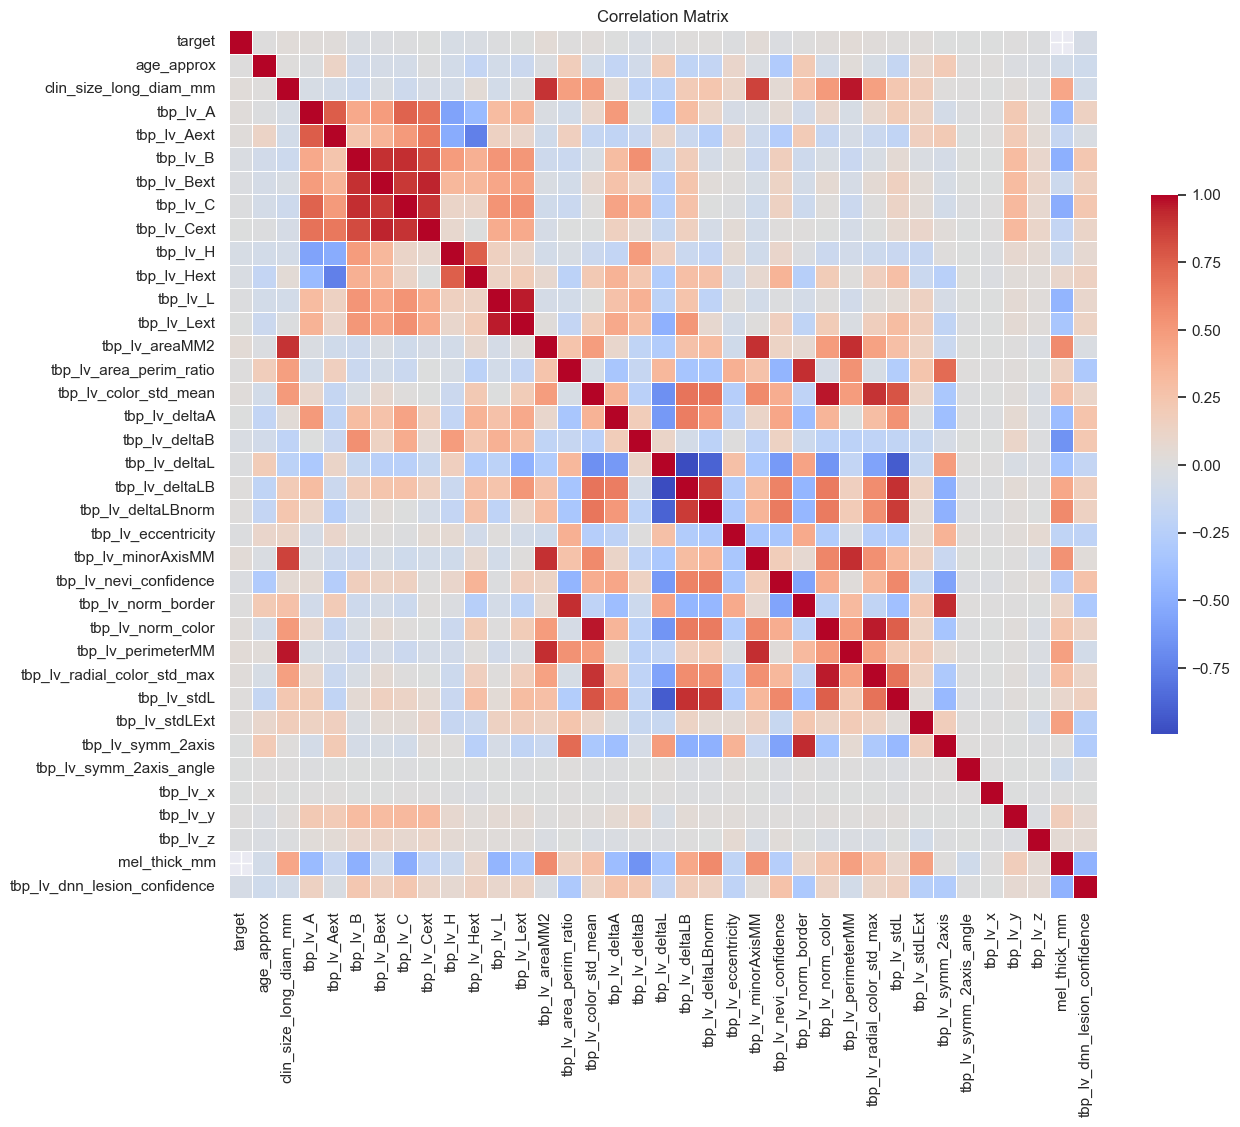

In [57]:
### Calculating the correlation matrix for the numeric data (including some categorical data)
correlation_matrix = metadata[numerics].corr()

#Set figure size
plt.figure(figsize=(14, 14))
#Make the heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

## cleaning data

#### >Age

In [58]:
# age : fill in with mean
# Calculate the mean of age_approx for each target group
mean_age_malign = metadata.loc[metadata["target"] == 1, "age_approx"].mean()
mean_age_benign = metadata.loc[metadata["target"] == 0, "age_approx"].mean()

# Define a function to fill NA based on the target value
def fill_na_by_target(row):
    if pd.isna(row['age_approx']):
        if row['target'] == 1:
            return mean_age_malign
        elif row['target'] == 0:
            return mean_age_benign
    return row['age_approx']

# Apply the function to the age_approx column
metadata['age_approx'] = metadata.apply(fill_na_by_target, axis=1)


#### > Creation indicator on image 

In [59]:
# data creation : indicator on image
metadata['global_contrast'] = metadata['tbp_lv_deltaA'] + metadata['tbp_lv_deltaB'] + metadata['tbp_lv_deltaL']
metadata['normalized_contrast'] = (metadata['tbp_lv_deltaA'] + metadata['tbp_lv_deltaB'] + metadata['tbp_lv_deltaL']) / 3
metadata['delta_E'] = ((metadata['tbp_lv_L'] - metadata['tbp_lv_Lext'])**2 + 
                      (metadata['tbp_lv_A'] - metadata['tbp_lv_Aext'])**2 + 
                      (metadata['tbp_lv_B'] - metadata['tbp_lv_Bext'])**2)**0.5
metadata['shape_irregularity'] = metadata['tbp_lv_eccentricity'] * metadata['tbp_lv_area_perim_ratio']
metadata['size_to_perimeter_ratio'] = metadata['clin_size_long_diam_mm'] / metadata['tbp_lv_perimeterMM']
metadata['color_asymmetry_ratio'] = metadata['tbp_lv_radial_color_std_max'] / metadata['tbp_lv_areaMM2']
metadata['size_to_area_ratio'] = metadata['clin_size_long_diam_mm'] / metadata['tbp_lv_areaMM2']
# luminance (light intensity) ratio between internal and  external lesion part
metadata['luminance_ratio'] = metadata['tbp_lv_L'] / metadata['tbp_lv_Lext']

# ChrominanceA (color intensity) ratio between internal and external lesion part
metadata['chroma_A_ratio'] = metadata['tbp_lv_A'] / metadata['tbp_lv_Aext']

# ChrominanceB (color intensity) ratio between internal and external lesion part
metadata['chroma_B_ratio'] = metadata['tbp_lv_B'] / metadata['tbp_lv_Bext']

#### > One-hot encoding for categorical features

In [60]:
# location
location=pd.get_dummies(metadata["tbp_lv_location"],prefix='category')
location = location.astype(int)


# Sex
sex_pat=pd.get_dummies(metadata["sex"],prefix='category')
sex_pat = sex_pat.astype(int)
#metadata = pd.concat([metadata, sex_pat], axis=1)

#Anatom_site_general
anatom=pd.get_dummies(metadata["anatom_site_general"],prefix='category')
anatom = anatom.astype(int)
anatom = anatom.drop(['category_head/neck'], axis=1)

#Concatane these new features with the dataset
metadata = pd.concat([metadata, location, sex_pat, anatom], axis=1)


#### > NA

In [61]:
# count NA
na_counts = metadata.isna().sum()

columns_with_na = na_counts[na_counts > 0].index

na_counts_by_target = metadata.groupby('target')[columns_with_na].apply(lambda x: x.isna().sum())

print(na_counts_by_target)


          sex  anatom_site_general  lesion_id  iddx_2  iddx_3  iddx_4  iddx_5  \
target                                                                          
0       11507                 5756     379001  399991  399994  400357  400665   
1          10                    0          0       0       0     151     393   

        mel_mitotic_index  mel_thick_mm  age_group  
target                                              
0                  400666        400666       2795  
1                     340           330          3  


- the features 'lesion_id','iddx_2','iddx_3','iddx_4','iddx_5', 'mel_mitotic_index','mel_thick_mm' shows important NA with target 0, it's normal as these features are linked to target 1 -> we can remove
- anatom_site_general as only NA with target 0 and sex mainly with target 0 (for target 1 <3% of the data) -> we can remove the row NA linked

In [62]:
# remove feature with lot of NA due to lake of value with target 0
metadata = metadata.drop(columns=['lesion_id','iddx_2','iddx_3','iddx_4','iddx_5','mel_mitotic_index','mel_thick_mm'])

# remove row for remaining NA (sex and anatom)
metadata = metadata.dropna()

#remove the Unknown category
metadata = metadata.drop(columns=['category_Unknown'])


## > Variable Selection

### > Split the dataframe

In [63]:

#from xgboost import DMatrix

#Select numerical variables
metadata_selection = metadata.select_dtypes(include=[float, int])

# Specify X and Y
X = metadata_selection.drop(columns=['target'])
Y = metadata_selection['target']


#split train, test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

#Weighted by df
train_weigth=sum(Y_train==0)/sum(Y_train==1)
test_weigth=sum(Y_test==0)/sum(Y_test==1)



### > Scale the dataframe

In [64]:
from sklearn.preprocessing import StandardScaler
def scaled_dataframe(df):
    # Identify the feature beginning with "category" (= feature transformed with OneHot)
    category_column = [col for col in df.columns if col.startswith('category')]

    df_No_category = df.drop(columns=category_column) # drop feature "category.."

    # Normalize
    scaler = StandardScaler()
    #df_scaled = pd.DataFrame(scaler.fit_transform(df_No_category), columns=df_No_category.index)
    df_scaled = pd.DataFrame(scaler.fit_transform(df_No_category), columns=df_No_category.columns, index=df_No_category.index)

    # create a combined df (with feature "category..." and normalize features

    df_category = df[category_column]
   
    df_combined = pd.concat([df_scaled, df_category], axis=1)

    # check if the number of roxw match
    if df_combined.shape[0] != df.shape[0]:
        raise ValueError(f"Number of rows don't match : {df_combined.shape[0]} vs {df.shape[0]}")
    
    return df_combined




# Transform X_train and X_test
X_train_scaled = scaled_dataframe(X_train)
X_test_scaled = scaled_dataframe(X_test)

#### > Random Forest

In [69]:

# Initialization
rf = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced_subsample')

# Fit RF model
rf_model=rf.fit(X_train, Y_train)


# Cross-validation with AUC as the scoring metric
cv_auc_rf = cross_val_score(rf, X_train, Y_train, cv=5, scoring='roc_auc')


# cv metrics
mean_auc_rf = cv_auc_rf.mean()
std_auc_rf = cv_auc_rf.std()

# Display 
print(f'Mean AUC from cross-validation: {mean_auc_rf}')
print(f'Standard deviation of AUC from cross-validation: {std_auc_rf}')
print(f'AUC scores from cross-validation: {cv_auc_rf}')




# Predict 
Y_predict_rf=rf_model.predict(X_test)
Y_hat_rf=rf_model.predict_proba(X_test)
# proba for AUC
Y_prob_rf = Y_hat_rf[:, 1] 


# Metrics
precision_rf,recall_rf,_=precision_recall_curve(Y_test, Y_prob_rf)
rf_auc_pr=auc(recall_rf,precision_rf)
rf_auc = roc_auc_score(Y_test, Y_prob_rf)

# Display metrics
print("AUC Score: ", rf_auc)
print("AUC Score PR: ", rf_auc_pr)

#register metrics
score = {}
score['RF'] = {'AUC': rf_auc, 'AUC_PR': rf_auc_pr}


# Importance features
importances_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

# Disply the importance
pd.set_option('display.max_rows', None)
print(feature_importance_rf)
pd.reset_option('display.max_rows')


Mean AUC from cross-validation: 0.7689814634318223
Standard deviation of AUC from cross-validation: 0.041802252065245946
AUC scores from cross-validation: [0.8063868  0.76735406 0.76190647 0.69600684 0.81325315]
AUC Score:  0.7657801393165863
AUC Score PR:  0.042932128552181356
                             Feature    Importance
8                           tbp_lv_H  8.342659e-02
1             clin_size_long_diam_mm  7.212607e-02
25                tbp_lv_perimeterMM  7.106507e-02
12                    tbp_lv_areaMM2  5.453241e-02
21                tbp_lv_minorAxisMM  4.840301e-02
16                     tbp_lv_deltaB  4.337030e-02
9                        tbp_lv_Hext  4.224309e-02
41                size_to_area_ratio  3.516802e-02
14             tbp_lv_color_std_mean  3.397047e-02
44                    chroma_B_ratio  3.196096e-02
24                 tbp_lv_norm_color  2.876236e-02
26       tbp_lv_radial_color_std_max  2.340453e-02
40             color_asymmetry_ratio  2.198712e-02
32     

## > Logistic regression

In [73]:



# Initialize the logistic regression model
log_Reg = LogisticRegression(random_state=42,  max_iter=10000)

# Initialize the RFE object with cross validation to select best features
rfecv= RFECV(estimator=log_Reg, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv_model=rfecv.fit(X_train, Y_train)

# Extract the cv score
cv_auc_rg = rfecv.cv_results_['mean_test_score']

# cv metrics
mean_auc_rg = cv_auc_rg.mean()
std_auc_rg = cv_auc_rg.std()

# Display metrics
print(f"Mean AUC: {mean_auc_rg}")
print(f"Standard Deviation of AUC: {std_auc_rg}")
print(f'AUC scores from cross-validation: {cv_auc_rg}')

# Display 
print(f'Mean AUC from cross-validation: {mean_auc_rf}')
print(f'Standard deviation of AUC from cross-validation: {std_auc_rf}')
print(f'AUC scores from cross-validation: {cv_auc_rf}')






#Forecast
Y_predict_rg=rfecv_model.predict(X_test)
Y_hat_rg=rfecv_model.predict_proba(X_test)

# proba for AUC
Y_prob_rg = Y_hat_rg[:, 1] 

# Metrics
precision_rg,recall_rg,_=precision_recall_curve(Y_test, Y_prob_rg)
rf_auc_pr_rg=auc(recall_rg,precision_rg)
rf_auc_rg = roc_auc_score(Y_test, Y_prob_rg)



# Display metrics
print("AUC Score: ", rf_auc_rg)
print("AUC Score PR: ", rf_auc_pr_rg)

#register metrics

score['Regression'] = {'AUC': rf_auc_rg, 'AUC_PR': rf_auc_pr_rg}


#Find out the optimal number of features
print(f"Optimal number of features: {rfecv_model.n_features_}")

# Show the ranking of features
print(f"Feature ranking: {rfecv_model.ranking_}")

# Get the selected features
selected_features_rg = X_train.columns[rfecv_model.support_]
print(f" Selected features: {selected_features_rg}")



Mean AUC: 0.8726252847376593
Standard Deviation of AUC: 0.057664117640433825
AUC scores from cross-validation: [0.60125219 0.68959021 0.7237696  0.72936905 0.77446832 0.82783344
 0.83753147 0.83518954 0.82941306 0.79032396 0.78965118 0.80168339
 0.81037529 0.82833307 0.83179947 0.83844461 0.87370433 0.87205922
 0.87975084 0.87998691 0.87761016 0.89044195 0.87844106 0.89172426
 0.89329976 0.88775149 0.88988524 0.89451507 0.89669818 0.89078979
 0.88235795 0.89214674 0.89362596 0.89383198 0.90137383 0.90199427
 0.89368657 0.8989276  0.90130024 0.89935622 0.89978178 0.90039641
 0.89713718 0.89715813 0.90288306 0.89971071 0.89987977 0.9013608
 0.90698652 0.90068818 0.90442003 0.90289413 0.904087   0.90411382
 0.90328255 0.90311419 0.90814021 0.90058462 0.90352143 0.90813137
 0.90867104 0.90261808 0.90358832 0.90915847 0.90563145 0.90961242
 0.91254797 0.91371757 0.9160239  0.9173619  0.91490469]
Mean AUC from cross-validation: 0.7689814634318223
Standard deviation of AUC from cross-validati

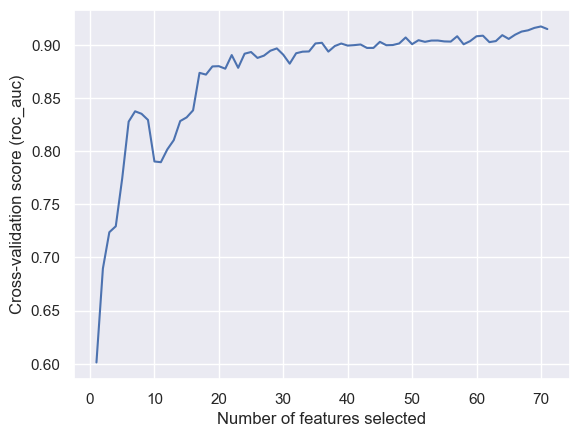

In [74]:
# Plot the number of features selected vs cross-validation score


plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (roc_auc)")
plt.plot(range(1, len(rfecv_model.cv_results_['mean_test_score']) + 1), rfecv_model.cv_results_['mean_test_score'])
plt.show()

# > XGBOOST

In [ ]:
#! pip install optuna

In [75]:

# compute weighted class
class_weight = sum(Y_train == 0) / sum(Y_train == 1)

# Function to use optuna
def xgb_objective(trial):
    # Hyperparameters
    params = {
        'objective': 'binary:logistic',
        'n_estimators': 200,
        'tree_method': 'hist',
        'random_state': 42,
        'use_label_encoder': False,
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.4, 1.0)

    }
  

    # XGboost
    clf = XGBClassifier(**params, scale_pos_weight=class_weight)

    # Crss validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

    # Compute mean
    scores = cross_val_score(clf, X_train_scaled, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    return scores.mean()

# Optimization with optuna
study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Meilleurs paramètres :", best_params)

# Train model with best parameter
best_xgb_model = XGBClassifier(**best_params, use_label_encoder=False, scale_pos_weight=class_weight)
best_xgb_model.fit(X_train_scaled, Y_train)

# Predict
Y_predict_xgb = best_xgb_model.predict(X_test_scaled)
Y_hat_xgb = best_xgb_model.predict_proba(X_test_scaled)

# Proba with AUC
Y_prob_xgb = Y_hat_xgb[:, 1]

# Metrics
precision_xgb, recall_xgb, _ = precision_recall_curve(Y_test, Y_prob_xgb)
rf_auc_pr_xgb = auc(recall_xgb, precision_xgb)
rf_auc_xgb = roc_auc_score(Y_test, Y_prob_xgb)

# Display metrics
print("AUC Score: ", rf_auc_xgb)
print("AUC Score PR: ", rf_auc_pr_xgb)

#register metrics
score['XGB'] = {'AUC': rf_auc_xgb, 'AUC_PR': rf_auc_pr_xgb}


[I 2024-10-24 10:45:34,962] A new study created in memory with name: no-name-0e8b3b2d-3937-4e56-8327-68885d8ffd32
[I 2024-10-24 10:49:14,080] Trial 0 finished with value: 0.9271354078214726 and parameters: {'learning_rate': 0.013562106042813285, 'max_depth': 8, 'lambda': 0.7661329893705235, 'alpha': 0.0037599803528034887, 'subsample': 0.4092809841306748, 'colsample_bytree': 0.7077801329683531, 'colsample_bynode': 0.9654578646387019}. Best is trial 0 with value: 0.9271354078214726.
[I 2024-10-24 10:52:04,014] Trial 1 finished with value: 0.9413978626146221 and parameters: {'learning_rate': 0.026775174284345185, 'max_depth': 5, 'lambda': 0.004617592079898043, 'alpha': 9.281141900350521, 'subsample': 0.7304591010852783, 'colsample_bytree': 0.7472330885323122, 'colsample_bynode': 0.7169528589003402}. Best is trial 1 with value: 0.9413978626146221.
[I 2024-10-24 10:54:35,088] Trial 2 finished with value: 0.9432419777614041 and parameters: {'learning_rate': 0.03042559203931371, 'max_depth': 

Meilleurs paramètres : {'learning_rate': 0.039381548688964214, 'max_depth': 4, 'lambda': 1.3487917592653944, 'alpha': 0.04746047690967229, 'subsample': 0.8533014175380595, 'colsample_bytree': 0.4008859715935444, 'colsample_bynode': 0.580576777513251}


C:\Users\admin\anaconda3\envs\env_DL_python3119\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC Score:  0.9256530646997361
AUC Score PR:  0.053569908264753434


In [76]:
# Train
X_scaled = scaled_dataframe(X)
best_xgb_model.fit(X_scaled, Y)

# Display importance feature
importance_weight = best_xgb_model.get_booster().get_score(importance_type='weight')
importance_gain = best_xgb_model.get_booster().get_score(importance_type='gain')

feature_names_X = X_scaled.columns
xgb_feature_importance_df = pd.DataFrame({'feature': [feature_names_X[int(f[1:])] if f[1:].isdigit() else f for f in importance_gain.keys()],
                                          'weigth': importance_weight.values(),
                                         'gain' :importance_gain.values() }).sort_values(by='gain', ascending=False)


# Display the importance
pd.set_option('display.max_rows', None)
print(xgb_feature_importance_df)
pd.reset_option('display.max_rows')




C:\Users\admin\anaconda3\envs\env_DL_python3119\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                             feature  weigth          gain
21                tbp_lv_minorAxisMM    45.0  17132.376953
8                           tbp_lv_H    70.0  15541.243164
25                tbp_lv_perimeterMM    70.0  11173.089844
45              category_Head & Neck    12.0  11020.606445
1             clin_size_long_diam_mm    78.0  10484.501953
16                     tbp_lv_deltaB    35.0   8629.993164
3                        tbp_lv_Aext    30.0   8047.965332
24                 tbp_lv_norm_color    43.0   7689.643066
44                    chroma_B_ratio    33.0   6841.757324
12                    tbp_lv_areaMM2    58.0   6820.243652
9                        tbp_lv_Hext    56.0   6763.313477
26       tbp_lv_radial_color_std_max    38.0   6150.003418
41                size_to_area_ratio    47.0   5767.523438
28                    tbp_lv_stdLExt    25.0   5282.584961
19                tbp_lv_deltaLBnorm    27.0   5281.899902
34      tbp_lv_dnn_lesion_confidence    52.0   5238.8647

In [77]:
#selection with SelectFromModel
selector = SelectFromModel(best_xgb_model, threshold=None, importance_getter='auto', prefit=True)
#selector = SelectFromModel(best_xgb_model, threshold=None, importance_getter='feature_importances_', prefit=True)
# Select the importan feature
X_scale_selected = selector.transform(X_scaled)

# Extract the name
selected_features_auto = X_scaled.columns[(selector.get_support())]

C:\Users\admin\anaconda3\envs\env_DL_python3119\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### > Select the model


In [78]:
score

{'RF': {'AUC': 0.7657801393165863, 'AUC_PR': 0.042932128552181356},
 'Regression': {'AUC': 0.9126733123072488, 'AUC_PR': 0.05129375523290316},
 'XGB': {'AUC': 0.9256530646997361, 'AUC_PR': 0.053569908264753434}}

-> the best model is xgboost

### > Create a metadatafile with selected feature ready for the CNN model 

In [80]:

metadata_feature_selected_auto = metadata.loc[:, selected_features_auto.tolist()]
metadata_feature_selected_auto_scaled=scaled_dataframe(metadata_feature_selected_auto)

# Create a new dataframe with the selected features
cleaned_metadata = pd.concat([metadata[['isic_id', 'target']], metadata_feature_selected_auto_scaled], axis=1)

cleaned_metadata.to_csv('cleaned_metadata.csv', index=False)

# Disply
print(f"Selected features: {selected_features_auto}")

Selected features: Index(['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_minorAxisMM', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdLExt', 'tbp_lv_y',
       'tbp_lv_dnn_lesion_confidence', 'normalized_contrast',
       'size_to_area_ratio', 'luminance_ratio', 'chroma_B_ratio',
       'category_Head & Neck'],
      dtype='object')


### > Check the auc result with the selected feature

In [81]:
Yb=cleaned_metadata['target']
Xb=cleaned_metadata.drop(['target','isic_id'],axis=1)

In [82]:
Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(Xb, Yb, test_size=0.2, stratify=Yb, random_state=42)


In [83]:
best_xgb_model.fit(Xb_train, Yb_train)

# Faire les prédictions
Yb_predict_xgb = best_xgb_model.predict(Xb_test)
Yb_hat_xgb = best_xgb_model.predict_proba(Xb_test)

# Proba pour AUC
Yb_prob_xgb = Yb_hat_xgb[:, 1]

# Metrics
precision_xgbb, recall_xgbb, _ = precision_recall_curve(Yb_test, Yb_prob_xgb)
rf_auc_pr_xgbb = auc(recall_xgbb, precision_xgbb)
rf_auc_xgbb = roc_auc_score(Yb_test, Yb_prob_xgb)

# Afficher les métriques
print("AUC Score: ", rf_auc_xgbb)
print("AUC Score PR: ", rf_auc_pr_xgbb)

C:\Users\admin\anaconda3\envs\env_DL_python3119\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC Score:  0.92972535457532
AUC Score PR:  0.08500123136918741


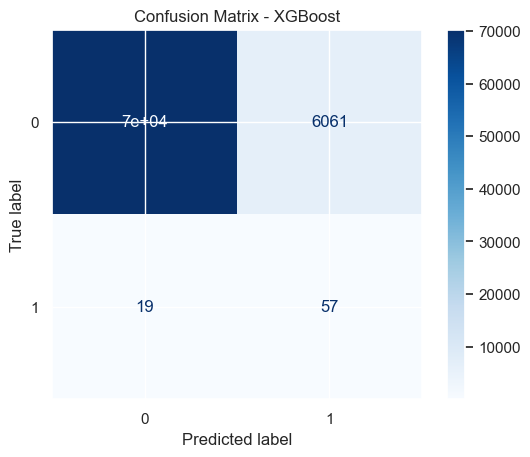

In [84]:
# Confusion matrix
conf_matrix = confusion_matrix(Yb_test, Yb_predict_xgb)

# Display matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()
